# Exercise 1
## Exercise 1a: Fashion MNIST

Image classification is a classical task in machine learning. MNIST serves as a good starting point for testing
out algorithms and learning. Some criticism that has been pointed out is that it is fairly easy to get good
(well above 95%) accuracy. In this exercise you will perform image classification on a similar dataset known
as Fashion MNIST. The dataset consists of 10 categories of different clothing, and the overall objective is
to find a feed-forward neural network which can distinguish images on the different sets of clothes. The
dataset contains 60,000 images for training and 10,000 for testing just as the ordinary MNIST. The images
are 28 x 28 pixels.

In [1]:
import os
import gzip
import numpy as np

def load_mnist(path, kind="train"):
    labels_path = os.path.join(path, "%s-labels-idx1-ubyte.gz" % kind)
    images_path = os.path.join(path, "%s-images-idx3-ubyte.gz" % kind)

    with gzip.open(labels_path, "rb") as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, "rb") as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(
            len(labels), 784
        )

    return images, labels


path = "./../resources/datasets/fashion_mnist/"

X_train, y_train = load_mnist(path, kind="train")
X_test, y_test = load_mnist(path, kind="t10k")

label_dict = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

1. Plot 16 random samples from the training set with the corresponding labels.

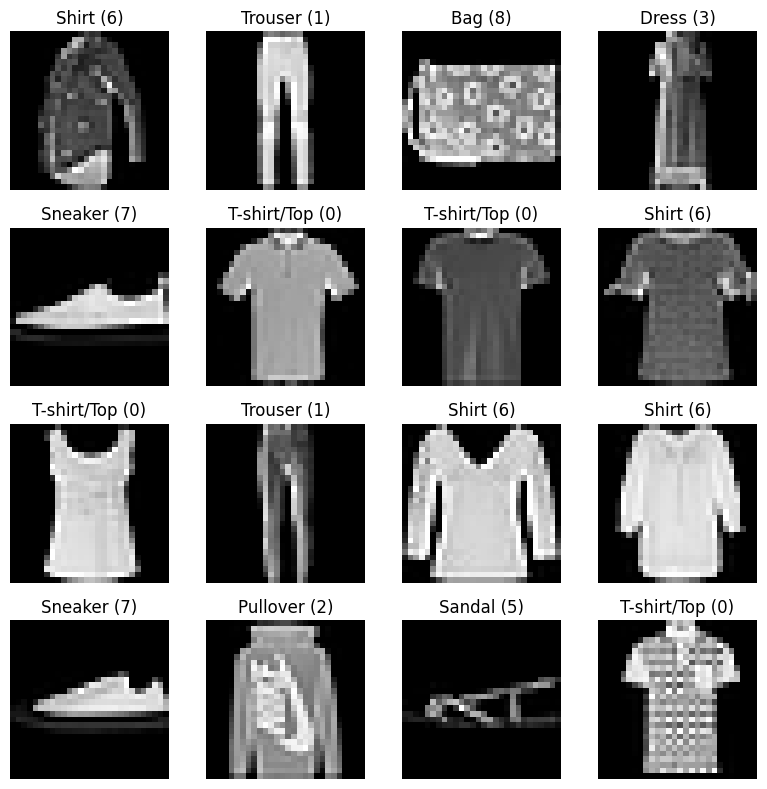

In [2]:
import matplotlib.pyplot as plt

np.random.seed(123)  # comment out this line to get different samples
sample_indices = np.random.choice(len(X_train), 16, replace=False)

sample_images = X_train[sample_indices]
sample_labels = y_train[sample_indices]

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    label = sample_labels[i]
    plt.title(f"{label_dict[label]} ({label})")
    plt.axis('off')
plt.tight_layout()
plt.show()

2. Train a multilayer perceptron to achieve as good accuracy as you can. There are numerous hyperparameters that we discussed in class which you can tweak, for instance: learning rate, number of and size of hidden layers, activation function and regularization (e.g. Ridge (known here as L2), and early stopping). You should make a structured search for the best hyperparameters that you can find.

Run the cell below to define functions that will be used to carry out randomized search for best combination of hyperparameters.

In [3]:
import torch
import time
from torch.utils.data import DataLoader, TensorDataset
from PerceptronNN import PerceptronNN
from IPython.display import clear_output

# Reset seed to ensure random configurations are generated
np.random.seed(None)

def train_model(num_samples=5, input_size=None, train_loader=None, test_loader=None):
    if input_size is None or train_loader is None or test_loader is None:
        raise ValueError("input_size, train_loader, and test_loader must be provided")

    best_accuracy = 0
    best_model = None
    best_hyperparameters = {}
    tried_configs = set()

    for i in range(num_samples):
        # Clear console output between runs to avoid clutter
        clear_output(wait=False)

        while True:
            config = generate_config()

            if config not in tried_configs:
                tried_configs.add(config)
                break

        learning_rate, num_epoch, num_layer, hidden_size = config
        
        with open("training_log.txt", "a") as f:
            def print_and_log(message):
                print(message)
                f.write(message + '\n')
                f.flush() # Ensure that the log file is updated immediately

            print_and_log("=" * 72)
            print_and_log("Training model with the following hyperparameters:")
            print_and_log(f"  Learning Rate: {learning_rate}")
            print_and_log(f"  Number of Epochs: {num_epoch}")
            print_and_log(f"  Number of Hidden Layers: {num_layer}")
            print_and_log(f"  Layer Sizes: {input_size} -> [{' -> '.join(map(str, hidden_size))}] -> 10\n")

            model = PerceptronNN(input_size, num_layer, hidden_size)

            start_time = time.time()
            model.train_model(train_loader, num_epochs=num_epoch, learning_rate=learning_rate)
            end_time = time.time()

            print_and_log("================ Model Evaluation ================")

            training_time = end_time - start_time
            formatted_time = format_time(training_time)
            print_and_log(f"Training time: {formatted_time}")

            accuracy = model.validate_model(test_loader)
            print_and_log(f"Accuracy on the test dataset: {accuracy:.2f}%")

            improvement_per_second = (accuracy) / training_time
            print_and_log(f"Improvement per second of computation: {improvement_per_second:.6f}%/s")

            print_and_log("=" * 72 + "\n\n\n")

            if accuracy > best_accuracy:
                best_model = model
                best_accuracy = accuracy
                best_hyperparameters = {
                    'learning_rate': learning_rate,
                    'num_epochs': num_epoch,
                    'num_layers': num_layer,
                    'hidden_size': hidden_size,
                }
    return (best_model, best_accuracy, best_hyperparameters)

def format_time(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours)}h {int(minutes)}m {seconds:.2f}s"

def generate_config():
    learning_rates = np.array([0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001])
    num_epochs = np.array([100, 250, 500])
    num_layers = np.array([1, 2, 3, 4])
    hidden_sizes_multipliers = np.array([0.125, 0.25, 0.5, 1])
    hidden_sizes = np.array([512, 256, 128, 64])

    learning_rate = np.random.choice(learning_rates)
    num_epoch = np.random.choice(num_epochs)
    num_layer = np.random.choice(num_layers)
    hidden_size_multiplier = np.random.choice(hidden_sizes_multipliers)
    hidden_size = tuple((hidden_sizes[:num_layer] * hidden_size_multiplier).astype(int)) # Ensure immutability for consistent configuration handling

    return (learning_rate, num_epoch, num_layer, hidden_size)

Run the cell below to define the data loaders and prepare the dataset for training and testing the neural network model.

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

input_size = 784  # 28x28 images
num_samples = 5 # number of random configurations to try

Run the cell below to test and validate 5 random configurations.
You can find results appended to `./training_log.txt`

In [ ]:
model, accuracy, hyperparameters = train_model(num_samples, input_size, train_loader, test_loader)

# Clear console output after model training to avoid clutter
clear_output(wait=False)

print(f"Best accuracy: {accuracy}%")
print("Hyperparameters Used:")
print(f"  Learning Rate: {hyperparameters['learning_rate']}")
print(f"  Number of Epochs: {hyperparameters['num_epochs']}")
print(f"  Number of Layers: {hyperparameters['num_layers']}")
print(f"  Hidden Layer Sizes: {hyperparameters['hidden_size']}")

## Observations
I ran 15 different samples and made the following observations:  
- Models with 1 or 2 hidden layers achieve a maximum accuracy of 87.48%, while models with 3 or 4 hidden layers achieve a maximum accuracy of 88.90%. The difference in accuracy between these categories is approximately 1.42%.
- The difference in average training time between more complicated and less complicated models is negligible for this dataset.
- Larger layer sizes (512 -> 256 -> 128) lead to better accuracy, achieving up to 88.90%, compared to smaller ones (64 -> 32 -> 16 -> 8) which achieved a maximum of 87.98%. This represents an improvement of about 0.92% in accuracy.
- Out of the 15 models, 12 stopped early, indicating a 80% tendency to prevent overfitting by halting when the loss change was less than 1e-4.
- All models experienced diminishing returns, struggling to improve accuracy beyond 85%, with none achieving 90% or higher.
- Lower learning rates (1e-05 or 5e-06) resulted in slower convergence and suboptimal accuracy, with none achieving the best results, highlighting the importance of a balanced learning rate for effective training.

The best set of hyperparameters observed was:  
- Learning Rate: 0.0005
- Number of Epochs: 50
- Number of Hidden Layers: 3
- Layer Sizes: 784 -> [256 -> 128 -> 64] -> 10

Across several different runs it leads to an average accuracy of ~88.5%

## Conclusion
A learning rate between 0.0001 and 0.001 seems to be the sweet spot for effective training, with lower rates experiencing diminishing convergence rate.

Early stopping effectively prevents overfitting by halting training when improvements are minimal. While more complex models can achieve higher accuracy, the additional training time is often negligible, making them a viable choice.

3 to 4 hidden layers and pyramid scheme of layer sizes starting with 256 neurons on the first hidden layer with number of neurons halving on each subsequent layer seems to be the sweet spot for accuracy. 512 neurons on the first layer are also fine, but it significantly increases training time whilst providing marginal improvement. Further increase in model complexity likely doesn't provide benefits due to the insufficient complexity of the data. Fashion MNIST, whilst being more complicated than the original MNIST dataset, still conists of simple 28x28 images with overlapping classes, which means the amount of information a model can extract from the data is limited and a direct increase of model complexity provides neglible improvements after certain point. The problem is further exacerbated by class overlapping.

Potential improvements might include:
- Introducing more sophisticated optimization techniques, such as simulated annealing, to increase the likelihood of finding global rather than local minima and reducing the number of samples needed for new discoveries.
- Implementing cross-validation techniques to enhance model robustness and prevent overfitting.
- Exploring different neural network architectures, such as convolutional neural networks (CNNs), which are better suited for image classification tasks.
- Leveraging regularization techniques (particularly L1 and L2) to prevent overfitting
- Further exploring possible combinations of hyperparameters through randomized testing

### You can run the cell below to validate the chosen set of hyperparameters across 5 different runs.

In [ ]:
accuracies = []

for i in range(5):
    model = PerceptronNN(input_size=784, num_layer=3, hidden_size=[256, 128, 64])
    model.train_model(train_loader, num_epochs=50, learning_rate=0.0005)
    accuracy = model.validate_model(test_loader)
    accuracies.append(accuracy)
    print(f"Accuracy for run {i+1}: {accuracy:.2f}%\n")

average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average accuracy over 5 runs: {average_accuracy:.2f}%")

## Exercise 1b: Fashion MNIST analysis and further extension
We will continue to work on the Fashion MNIST data (and our model) from Exercise 1a. Using the final
model found in 1a you should go in and investigate the results, and carry the analysis further. The specifics
of the exercise are listed in bullet form below. You should do the following:

- Plot the confusion matrix. Which are the easy/hard categories to classify? Are there any particular
classes that often gets mixed together?
- Select two classes that exhibit some misclassifications between them, and make a visual inspection of
the misclassifications (if there are too many a subset is sufficient) by means of plotting the misclassified
examples. Is it reasonable that the model makes these misinterpretations? Are the examples difficult
for human eyes? Comparing to the cases in which it correctly classifies are the difficult samples
different? Write a short text describing your thought on the subject, and also include images as
evidence supporting your viewpoints.

Run the cell below to train and validate the model

In [21]:
# Setting a seed for reproducability
np.random.seed(123)

model = PerceptronNN(input_size=784, num_layer=3, hidden_size=[256, 128, 64])
model.train_model(train_loader, num_epochs=50, learning_rate=0.0005)
accuracy, true_labels, predictions = model.validate_model(test_loader)

===== Start of Training =====
Epoch 0, Average Loss: 0.5324
Epoch 5, Average Loss: 0.2985
Epoch 10, Average Loss: 0.2544
Epoch 15, Average Loss: 0.2213
Epoch 20, Average Loss: 0.2023
Epoch 25, Average Loss: 0.1806
Epoch 30, Average Loss: 0.1693
Epoch 35, Average Loss: 0.1558
Epoch 40, Average Loss: 0.1490
Epoch 45, Average Loss: 0.1375
Epoch 50, Average Loss: 0.1225
====== End of Training ======



Run the cell below to plot the confusion matrix

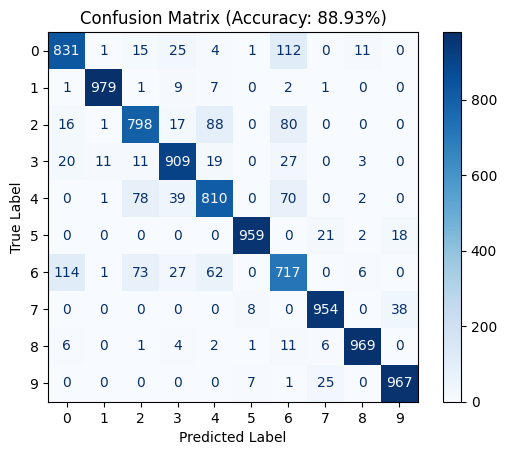

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f}%)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

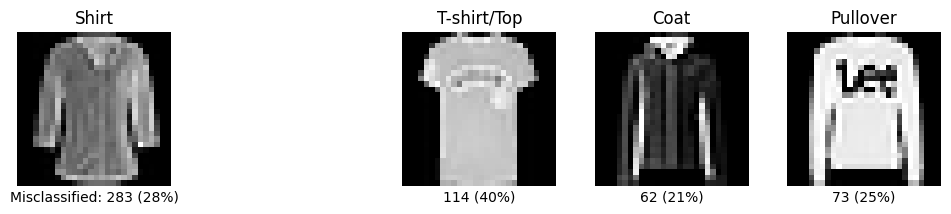

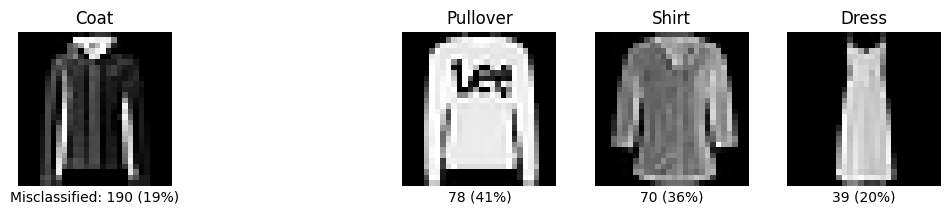

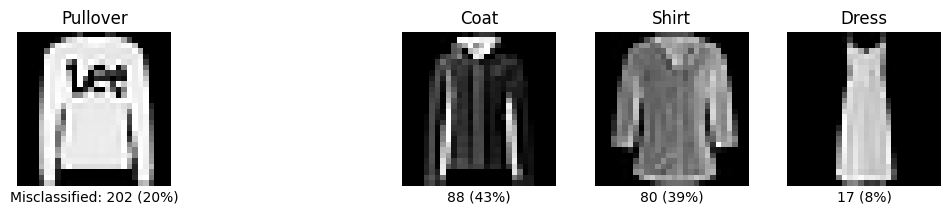

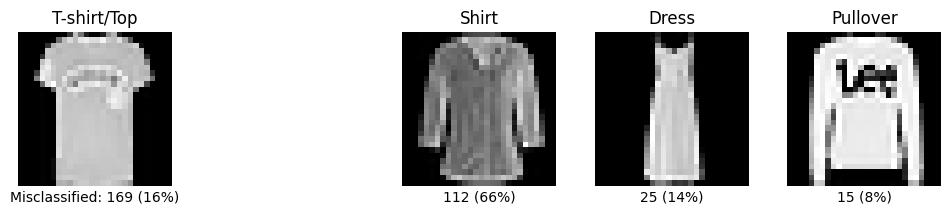

In [114]:
def plot_images(image_list, label_list, misclass_counts, misclass_percentages):
    fig, axes = plt.subplots(1, len(image_list) + 1, figsize=(12, 2))
    
    for index, axis in enumerate(axes):
        # Leave the second axis empty for visual separation after the first image, which represents the true label
        if index == 1:
            axis.axis('off')
            continue
        
        # Adjust index to account for the skipped axis
        img_index = index if index == 0 else index - 1
        image, label = image_list[img_index], label_list[img_index]
        misclass_count, misclass_percentage = misclass_counts[img_index], misclass_percentages[img_index]
        
        axis.imshow(image.reshape(28, 28), cmap='gray')
        axis.set_title(label_dict.get(label), loc='center')
        axis.axis('off')
        

        if img_index == 0:
            misclass_text = f"Misclassified: {misclass_count} ({int(misclass_percentage)}%)"
        else:
            misclass_text = f"{misclass_count} ({int(misclass_percentage)}%)"
        axis.text(0.5, -0.1, misclass_text, size=10, ha="center", transform=axis.transAxes)
    plt.show()

def get_images_by_label(dataset, target_label, max_images=1):
    return [image.numpy().squeeze() for image, label in dataset if label == target_label][:max_images]

def calculate_misclassification_metrics(true_label, misclassified_labels):
    # Get the classification results for the true label
    label_classification = cm[true_label]
    total_label_images = sum(label_classification)
    total_misclassified = total_label_images - label_classification[true_label]
    
    # Calculate misclassification counts and percentages for each misclassified label
    misclass_counts = [label_classification[label] for label in misclassified_labels]
    misclass_percentages = [(count / total_misclassified) * 100 for count in misclass_counts]
    total_misclass_percentage = (total_misclassified / total_label_images) * 100
    
    return total_misclassified, misclass_counts, total_misclass_percentage, misclass_percentages

def plot_misclassifications(true_label, misclassified_labels):
    # Get images of the true label
    image_list = get_images_by_label(test_loader.dataset, true_label)
    label_list = [true_label]
    
    # Calculate misclassification metrics
    total_misclassified, misclass_counts, total_misclass_percentage, misclass_percentages = (
        calculate_misclassification_metrics(true_label, misclassified_labels)
    )
    
    # Include total misclassified count and percentage in the lists
    misclass_counts = [total_misclassified] + misclass_counts
    misclass_percentages = [total_misclass_percentage] + misclass_percentages
    
    # Extend image and label lists with misclassified labels
    for label in misclassified_labels:
        image_list.extend(get_images_by_label(test_loader.dataset, label))
        label_list.append(label)
    
    # Plot the images with their misclassification statistics
    plot_images(image_list, label_list, misclass_counts, misclass_percentages)

# Dictionary defining scenarios of misclassifications to analyze
misclassification_scenarios = {
    6: [0, 4, 2],
    4: [2, 6, 3],
    2: [4, 6, 3],
    0: [6, 3, 2]
}

# Iterate over each scenario and plot the misclassifications
for true_label, misclassified_labels in misclassification_scenarios.items():
    plot_misclassifications(true_label, misclassified_labels)


# Observations
Shirt and T-Shirt frequently get misclassified as one another, while Coat is often misclassified as Pullover, Shirt, and, sometimes, Dress. Pullover tends to be mistaken for Coat and Shirt. Together, these five categories are the hardest to classify.

These misclassifications are reasonable for a simple multilayer perceptron. An MLP processes images by comparing them pixel by pixel, treating each pixel with equal weight. As a result, the model focuses on shape and color similarity rather than on specific details. In contrast, humans can recognize important features, such as the short sleeves on a T-shirt or the more bulky and dark appearance of a coat versus the slimmer, lighter look of a pullover. For the MLP, however, these distinctions become secondary because the details occupy only a small portion of the total pixel set.

One way to address these challenges would be choosing a convolutional neural network (CNN) architecture. Unlike an MLP, a CNN can analyze patterns locally, focusing on the details in a way that resembles human perception. By capturing local cues like sleeve length or fabric bulkiness, a CNN architecture is better suited to identify the characteristics that define each clothing item.